# Polynomial regression approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import rasterio
from rasterio import mask

In [2]:
# Step 1: Load raster data and preprocess
# Read the hyperspectral image (assuming you have a raster file)
pca_hs_image_path = 'D:\\MasterThesis\\test_data_elbow\\ang20180729t212542rfl\\result\\ang20180729t212542_rfl_v2r2_img_rectified\\SPCA\\PCA\\OutputPCA_30_PCs'


In [3]:
with rasterio.open(pca_hs_image_path) as src:
    pca_hs_image = src.read([1, 2, 3, 4])  # Read the first 4 PCA bands
    profile = src.profile

In [32]:
type(cleaned_pca_image)

numpy.ndarray

In [33]:
cleaned_pca_image

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

In [9]:
pca_hs_image.shape

(4, 3694, 1581)

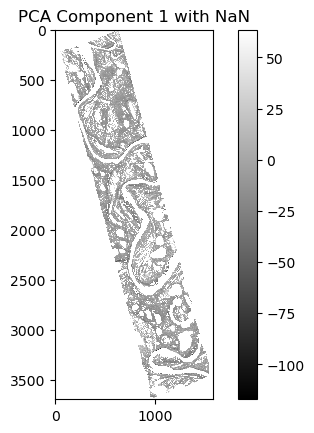

In [24]:
# Plot PCA Component 1, ignoring NaN
plt.imshow(pca_hs_image[0], cmap='gray', interpolation='none')
plt.colorbar()
plt.title("PCA Component 1 with NaN")
plt.show()

In [25]:
# Mask rows and columns with NaNs
valid_rows = ~np.isnan(pca_hs_image).all(axis=(0, 2))  # Keep rows without all NaNs
valid_cols = ~np.isnan(pca_hs_image).all(axis=(0, 1))  # Keep cols without all NaNs

# Apply mask
cleaned_pca_image = pca_hs_image[:, valid_rows, :][:, :, valid_cols]


In [26]:
cleaned_pca_image.shape

(4, 3684, 1480)

In [27]:
# Compute statistics, ignoring NaN
means = [np.nanmean(cleaned_pca_image[i]) for i in range(4)]
variances = [np.nanvar(cleaned_pca_image[i]) for i in range(4)]

print("Means:", means)
print("Variances:", variances)


Means: [0.03681408, -0.019628016, 0.0021416678, 0.000789307]
Variances: [237.6137, 54.805763, 6.1321197, 3.3419163]


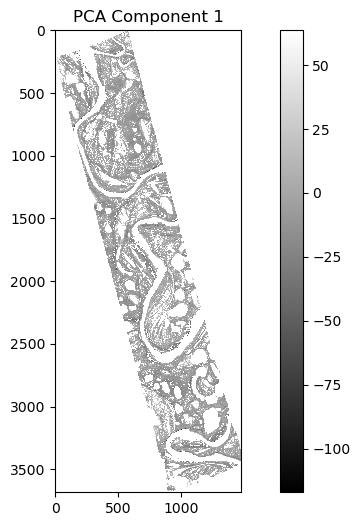

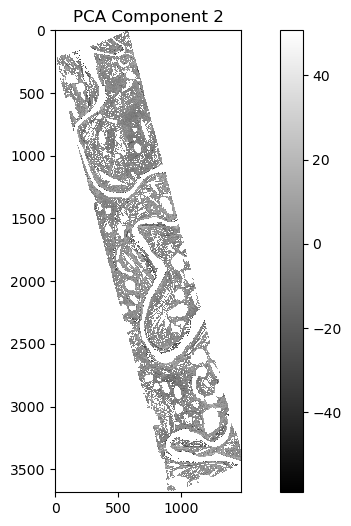

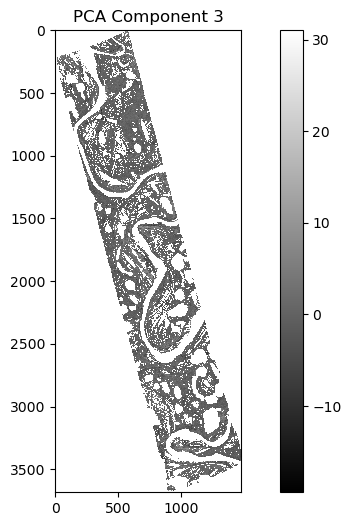

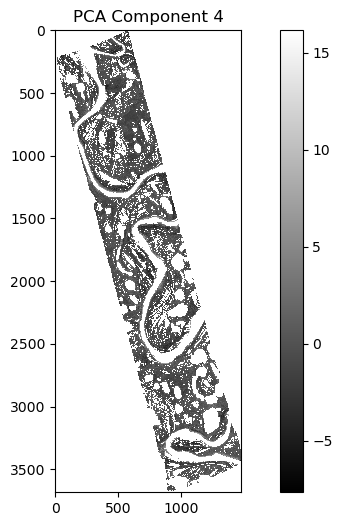

In [29]:
import matplotlib.pyplot as plt

# Iterate over the 4 PCA components and plot them
for i in range(4):
    plt.figure(figsize=(10, 6))
    plt.imshow(cleaned_pca_image[i], cmap='gray', interpolation='none')
    plt.title(f'PCA Component {i+1}')
    plt.colorbar()
    plt.show()


In [30]:
np.count_nonzero(np.isnan(cleaned_pca_image))

16321948

In [31]:
np.count_nonzero(~np.isnan(cleaned_pca_image))

5487332

In [14]:
d = pca_hs_image[np.logical_not(np.isnan(pca_hs_image))]

In [15]:
np.count_nonzero(~np.isnan(d))

5487332

In [16]:
d.shape

(5487332,)

In [ ]:
# Step 2: Downsample the raster (reduce spatial resolution)
# Here we use average pooling to downsample (equivalent to 'terra::aggregate')
def downsample_raster(raster_data, factor=5):
    new_shape = (raster_data.shape[1] // factor, raster_data.shape[2] // factor)
    return np.mean(raster_data[:, ::factor, ::factor], axis=(1, 2))

# Downsample the PCA data
pca_data_downsampled = downsample_raster(pca_hs_image)

In [ ]:
# Step 3: Reshape and preprocess the data
# Flatten the PCA data into a 2D array (each pixel is a row)
pca_data_reshaped = pca_hs_image.reshape((-1, pca_hs_image.shape[0])).T  # (n_samples, n_features)


In [ ]:
pca_data_reshaped = pca_data_reshaped[~np.isnan(pca_data_reshaped).any(axis=1)]  # Remove rows with NaN


In [ ]:
# Step 4: Calculate WSS for different k values
wss = []
k_range = range(2, 16)  # From 2 to 15 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pca_data_reshaped)
    wss.append(kmeans.inertia_)  # WSS is the inertia attribute of kmeans

In [ ]:
# Step 5: Use Kneedle to find the "elbow"
kneedle = KneeLocator(k_range, wss, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow

In [ ]:
# Step 6: Plot the WSS and highlight the optimal k
plt.figure(figsize=(8, 6))
plt.plot(k_range, wss, marker='o', label="WSS (within-cluster sum of squares)")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.legend()
plt.show()

In [ ]:
# Step 7: Print the optimal number of clusters
print(f"Optimal number of clusters (k) determined by Kneedle: {optimal_k}")